## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

## Import Data

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    #Reducing Cardinality
    top_ten_cities=df["City"].value_counts().head(10).index
    df["City"]=df["City"].apply(lambda c: c if c in top_ten_cities else "others")
    top_ten_states=df["State"].value_counts().head(10).index
    df["State"]=df["State"].apply(lambda c: c if c in top_ten_states else "others")
    
    ## Dealing with Outliers
    q1,q2 =df["Profit"].quantile([0.1,0.9])
    df=df[df["Profit"].between(q1,q2)]
    
    
    return df

In [3]:
df=wrangle("SampleSuperstore.csv")
df.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,others,others,42420,South,Furniture,Bookcases,261.960,2,0.0,41.9136
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.620,2,0.0,6.8714
4,Standard Class,Consumer,United States,others,Florida,33311,South,Office Supplies,Storage,22.368,2,0.2,2.5164
5,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,Furnishings,48.860,7,0.0,14.1694
6,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Art,7.280,4,0.0,1.9656


## Exploratory Data Analysis

In [4]:
print(df.shape)
df.info()

(7994, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7994 entries, 0 to 9993
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     7994 non-null   object 
 1   Segment       7994 non-null   object 
 2   Country       7994 non-null   object 
 3   City          7994 non-null   object 
 4   State         7994 non-null   object 
 5   Postal Code   7994 non-null   int64  
 6   Region        7994 non-null   object 
 7   Category      7994 non-null   object 
 8   Sub-Category  7994 non-null   object 
 9   Sales         7994 non-null   float64
 10  Quantity      7994 non-null   int64  
 11  Discount      7994 non-null   float64
 12  Profit        7994 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 874.3+ KB


### checking for missing values


In [5]:
### checking for missing values
df.isnull().sum()

Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

### checking for high cardinality categorical data


In [6]:
### checking for high cardinality categorical data
df.select_dtypes("object").nunique()

Ship Mode        4
Segment          3
Country          1
City            11
State           11
Region           4
Category         3
Sub-Category    17
dtype: int64

### Checking for Multicollinearity


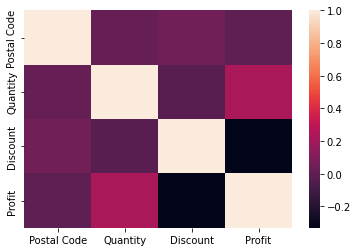

In [7]:
### Checking for Multicollinearity
corr_matrix=df.select_dtypes("number").drop("Sales",axis=1).corr()
sns.heatmap(corr_matrix);

### Profit Distribution of Cities


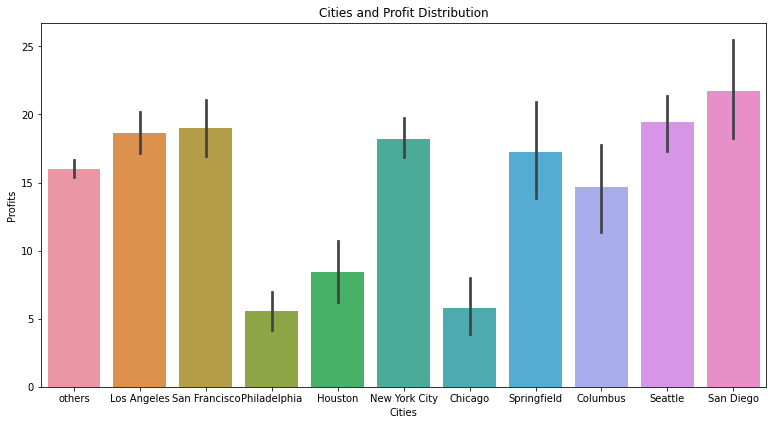

In [8]:
### Profit Distribution of Cities
dims = (13,6.7)
fig, ax=plt.subplots(figsize=dims)
sns.barplot(x=df["City"],
           y=df["Profit"],
           ax=ax)
plt.ylabel("Profits")
plt.xlabel("Cities")
plt.title("Cities and Profit Distribution")

### Checking for outliers


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


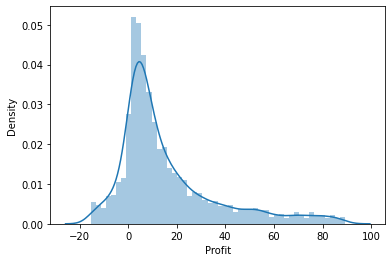

In [9]:
### Checking for outliers
sns.distplot(df["Profit"])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Quantity', ylabel='Density'>

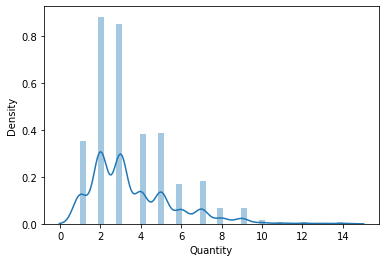

In [10]:
#Checking for outliers
sns.distplot(df["Quantity"])

### Sales distribution of Segment


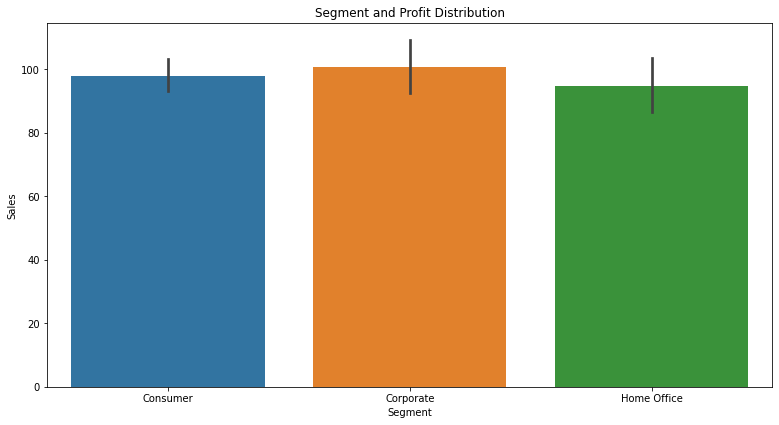

In [11]:
### Sales distribution of Segment
ims = (13,6.7)
fig, ax=plt.subplots(figsize=dims)
sns.barplot(x=df["Segment"],
           y=df["Sales"],
           ax=ax)
plt.ylabel("Sales")
plt.xlabel("Segment")
plt.title("Segment and Profit Distribution");

## Splitting

In [12]:
target="Sales"
X=df.drop(target,axis=1)
y=df[target]
print(X.shape)
print(y.shape)

(7994, 12)
(7994,)


In [13]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [14]:
##  baseline mean absolute error
y_mean=y.mean()
y_mean_pred=[y_mean] * len(y_train)
baseline_mae=mean_absolute_error(y_train,y_mean_pred)
print(round(baseline_mae,2))

99.21


## Iteration

In [15]:
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                     Ridge())
model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Ship Mode', 'Segment', 'Country', 'City',
                                     'State', 'Region', 'Category',
                                     'Sub-Category'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [16]:
# Making Prediction with the training data
y_train_pred = model.predict(X_train)

In [17]:
#Evaluating the model 
mae_train=mean_absolute_error(y_train, y_train_pred)
print(round(mae_train,2))

59.36


## Evaluation

In [18]:
y_test_pred = model.predict(X_test)

In [19]:
mae_test = mean_absolute_error(y_test, y_test_pred)
print(round(mae_test,2))

63.37


## Communication

In [20]:
features = model.named_steps["onehotencoder"].get_feature_names()
importance = model.named_steps["ridge"].coef_

In [21]:
feat_imf = pd.Series(importance, index=features).sort_values()

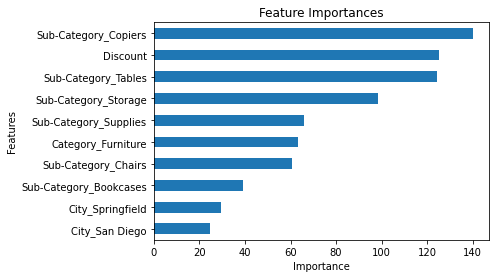

In [22]:
feat_imf.tail(10).plot(kind="barh")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Feature Importances")